# $\nu_e$ Notebook

## Imports and constants

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.externals import joblib
from helpfunction import sciNot,sciNot2,effErr,maxscore,minscore,avgscore

In [2]:
%matplotlib inline

In [3]:
pd.options.display.max_columns = 999
gr      = 1.618

mass_p= 0.93827 #GeV
mass_e= 0.00511 #GeV
# Minimum reconstructable energies:
min_e = 0.02+mass_e # 20MeV
min_p = 0.04+mass_p # 40MeV
min_pi = 0.17 # 170MeV


z_dead_start = 675
z_dead_end=z_dead_start+100

nue_method = "nue_predict"
nue_cut = 0.87

input_dir = "../Input/pandora_pdg_cut/"
output_dir = "../Output/Nue_true_plots/"

columns_train = ['tr_mu_max','sh_mu_max',
                 'sh_e_max','sh_cle_max',"sh_cle_lee_max",
                 'tr_cle_max',
                 "total_spacepoint_containment","numu_cuts","has_track",
                 "vtx_activity_nr","reconstructed_energy",
                 'sh_e_avg',#"tr_mu_avg",'sh_mu_avg'
                 "total_len","total_cos"
                ]

## Functions

In [4]:
def veclencos(row):
    x1 = row["vx"]
    y1 = row["vy"]
    z1 = row["vz"]
    x2 = row["chargecenter_x"]
    y2 = row["chargecenter_y"]
    z2 = row["chargecenter_z"]
    
    x = np.array([x2-x1,y2-y1,z2-z1])
    dist = np.linalg.norm(x)
    cos = np.dot(x,np.array([0,0,1]))/dist
    return pd.Series({"total_len":dist,"total_cos":cos})

def true_proton(row):
    for pdg,E in zip(*row[["nu_daughters_pdg","nu_daughters_E"]]):
        if pdg==2212 and E>min_p:
            return True
        
    return False
        
def true_pion(row):
    for pdg,E in zip(*row[["nu_daughters_pdg","nu_daughters_E"]]):
        if pdg in [-211,211,111] and E>min_pi:
            return True
        
    return False

def reco_lepton_theta(row):
    reco_e_theta = -10
    reco_e_energy_one = -10
    if len(row["shower_closest_electron_score"])>0:
        score_index = np.argmax(row["shower_closest_electron_score"])
        sh_index = row["shower_score_index"][score_index]
        #if len(sh_index)<1:
        #    print('ERROR')
        reco_e_theta = row["shower_theta"][sh_index]
        reco_e_energy_one = row["shower_energy_w"][sh_index]
        
    if reco_e_theta== -10:
        if len(row["track_closest_electron_score"])>0:
            score_index = np.argmax(row["track_closest_electron_score"])
            tr_index = row["track_score_index"][score_index]
            reco_e_theta = row["track_theta"][tr_index]
            reco_e_energy_one = row["track_energy_w"][tr_index]
        
    return pd.Series((reco_e_theta, reco_e_energy_one))


def reco_lepton_energy(row):
    param = 0.5
    reco_e_E = 0
    
    if len(row["shower_electron_score"])>0:
        if max(row["shower_electron_score"])>param:
            score_index = np.where(row["shower_electron_score"]>param)
            sh_index = np.array(row["shower_score_index"])[np.array(score_index[0])]
            reco_e_E += sum(np.array(row["shower_energy_w"])[sh_index])
        
    if len(row["track_electron_score"])>0:
        if max(row["track_electron_score"])>param:
            score_index = np.where(row["track_electron_score"]>param)
            tr_index = np.array(row["track_score_index"])[score_index]
            reco_e_E += sum(np.array(row["track_energy_w"])[tr_index])
        
    return reco_e_E

def addScores(df_all):
    df_all=df_all.copy()
    df_all['tr_mu_max']=df_all['track_muon_score'].apply(maxscore)
    df_all['sh_mu_max']=df_all['shower_muon_score'].apply(maxscore)    
    
    df_all['tr_e_max_temp']=df_all['track_electron_score'].apply(maxscore)
    mean = df_all['tr_e_max_temp'][df_all['tr_e_max_temp']>0].mean()
    df_all['tr_e_max']=df_all['tr_e_max_temp'].apply(lambda x: mean if x==0 else x)
    
    df_all['sh_e_max_temp']=df_all['shower_electron_score'].apply(maxscore)
    mean = df_all['sh_e_max_temp'][df_all['sh_e_max_temp']>0].mean()
    df_all['sh_e_max']=df_all['sh_e_max_temp'].apply(lambda x: mean if x==0 else x)

    df_all['sh_e_avg']=df_all['shower_electron_score'].apply(avgscore)
    
    df_all['tr_cle_max_temp']=df_all['track_closest_electron_score'].apply(maxscore)
    mean = df_all['tr_cle_max_temp'][df_all['tr_cle_max_temp']>0].mean()
    df_all['tr_cle_max']=df_all['tr_cle_max_temp'].apply(lambda x: mean if x==0 else x)

    df_all['sh_cle_max_temp']=df_all['shower_closest_electron_score'].apply(maxscore)
    mean = df_all['sh_cle_max_temp'][df_all['sh_cle_max_temp']>0].mean()
    df_all['sh_cle_max']=df_all['sh_cle_max_temp'].apply(lambda x: mean if x==0 else x)
    
    df_all['sh_cle_lee_max_temp']=df_all['shower_cle_lee_score'].apply(maxscore)
    mean = df_all['sh_cle_lee_max_temp'][df_all['sh_cle_lee_max_temp']>0].mean()
    df_all['sh_cle_lee_max']=df_all['sh_cle_lee_max_temp'].apply(lambda x: mean if x==0 else x)
    
    
    df_all.drop(['sh_cle_max_temp', 'tr_cle_max_temp', "sh_cle_lee_max_temp", "sh_e_max_temp","tr_e_max_temp"], axis=1)
    df_all['sh_energy']=df_all['shower_energy_w'].apply(lambda x: sum(x))  
    df_all["n_objects"]=df_all["n_showers"]+df_all["n_tracks"]
    df_all["has_track"]=df_all["n_tracks"]>0
    
    return df_all

## Preparing dataframes

In [5]:
df_nue_test       = pd.read_pickle(input_dir+'XGB_out/nue_test56789_xgb.pckl')
df_nue_train      = pd.read_pickle(input_dir+'XGB_out/nue_train01234_xgb.pckl')
df_nue_nonpassed  = pd.read_pickle(input_dir+'nue/nue_nonpassed.pckl')

In [6]:
dfs = [df_nue_test,df_nue_train]
str_query_unresponsive_z = '~( @z_dead_start < vz < @z_dead_end)'

for df in dfs:
    df["reconstructed_energy"] = df.apply(lambda x: sum(x["track_energy_w"])+sum(x["shower_energy_w"]),axis=1) 
    df.query(str_query_unresponsive_z, inplace=True)
    dftemp = df.apply(veclencos,axis=1)
    df["total_len"] = dftemp["total_len"]
    df["total_cos"] = dftemp["total_cos"]
    
df_nue_test = addScores(df_nue_test)
df_nue_train = addScores(df_nue_train)

df_nue_test[["reco_lepton_theta","reco_lepton_E_one"]]=df_nue_test.apply(reco_lepton_theta,axis=1)
df_nue_test["reco_lepton_energy"]=df_nue_test.apply(reco_lepton_energy,axis=1)
df_nue_test['true_proton']= df_nue_test.apply(true_proton,axis=1)
df_nue_test['true_pion']= df_nue_test.apply(true_pion,axis=1)

In [7]:
model = joblib.load(input_dir+'XGBoost/model_nue.pkl')
df_nue_test["nue_predict"]  = model.predict_proba(df_nue_test[columns_train].as_matrix())[:,1]
df_nue_train["nue_predict"]  = model.predict_proba(df_nue_train[columns_train].as_matrix())[:,1]
df_nue_passed = pd.concat([df_nue_train,df_nue_test],ignore_index=True,copy=True)

print('Passed: ',len(df_nue_passed.index),' entries.')
print('Not-passed: ',len(df_nue_nonpassed.index),' entries.')
print('weighted total :',str(sum(df_nue_passed['bnbweight'])+sum(df_nue_nonpassed['bnbweight']) ))
print('pre-cuts passed:',str(sum(df_nue_passed['bnbweight'])))
print('final selection :',str(sum(df_nue_passed.query("nue_predict>@nue_cut")['bnbweight'])))
print('final selection pure :',str(sum(df_nue_passed.query("nue_predict>@nue_cut & category==2")['bnbweight'])))

Passed:  67610  entries.
Not-passed:  43147  entries.
weighted total : 81769.29231516298
pre-cuts passed: 51089.608100738384
final selection : 14658.007711584092
final selection pure : 14061.193814419514


## Plots

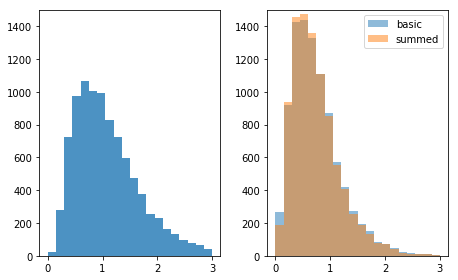

In [20]:
str_query =  "nue_predict>@nue_cut & category==2"
df_nue_test_final = df_nue_test.query(str_query)

fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(4*gr,4),sharey=False,sharex=False)

ax[1].hist(df_nue_test_final["reco_lepton_energy"],bins=20,range=(0,3.0),alpha=0.5,label="basic")
ax[1].hist(df_nue_test_final["reco_lepton_E_one"],bins=20,range=(0,3.0),alpha=0.5,label="summed")
ax[0].hist(df_nue_test_final["lepton_E"],bins=20,range=(0,3.0),alpha=0.8)
ax[1].legend()
ax[0].set_ylim(0,1500)
ax[1].set_ylim(0,1500)
fig.tight_layout()

/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/home/wouter/Documents/Jupyter/LEE_analyzer/Notebooks/helpfunction.py:54: RuntimeWarning: invalid value encountered in true_divide
  return np.sqrt(teller*(1-teller/noemer))/noemer


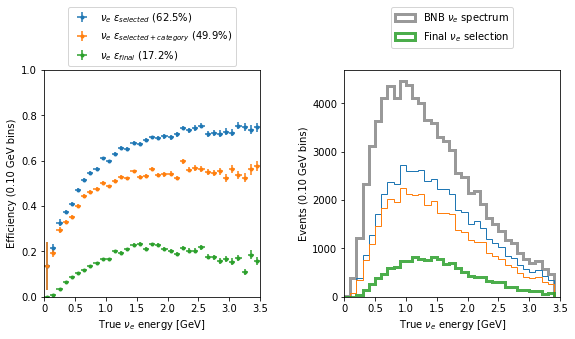

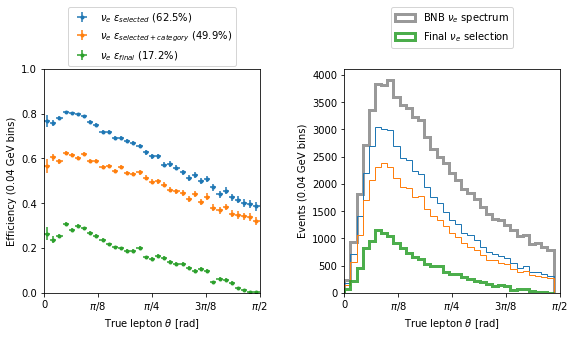

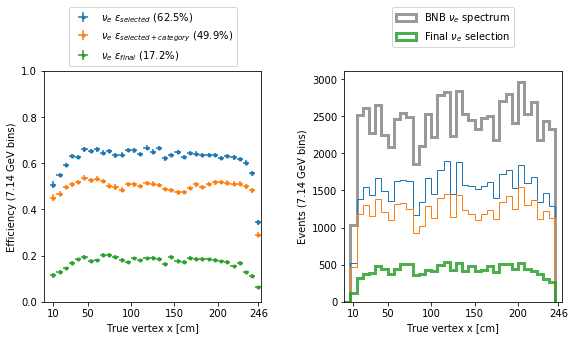

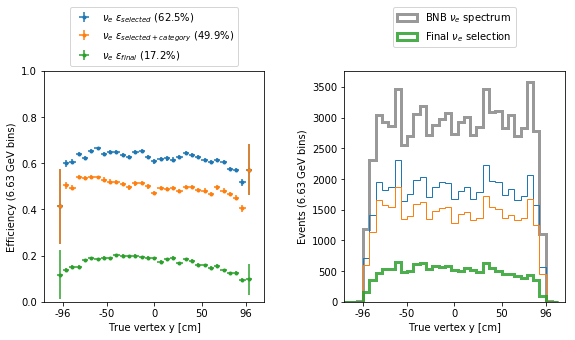

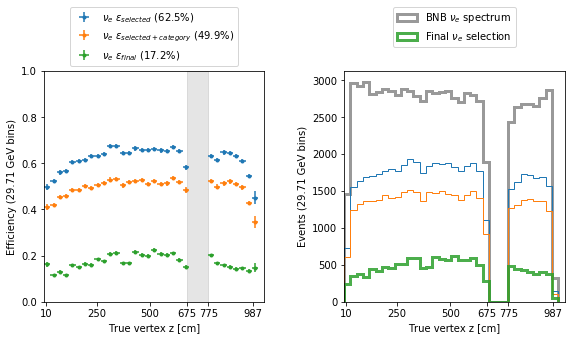

In [8]:
str_queries =  ["nu_E>0","nu_E>0","category==2","nue_predict>@nue_cut & category==2"]
dfs = [df_nue_nonpassed,df_nue_passed,df_nue_passed,df_nue_passed]

# ( x_axis field, x_min, x_max, bins, step, label)
x_axis_arr = [("nu_E", 0, 3.5, 35, r'True $\nu_e$ energy [GeV]'), 
              ("lepton_theta", 0, np.pi/2, 35, r'True lepton $\theta$ [rad]'), 
              #("lepton_phi", 0, np.pi, 35, r'True $\nu_e$ energy [GeV]'), 
              ("true_vx_sce", 0, 250, 35, r'True vertex x [cm]'), 
              ("true_vy_sce", -116, 116, 35, r'True vertex y [cm]'), 
              ("true_vz_sce", 0, 1040, 35, r'True vertex z [cm]')]

for i,x_axis in enumerate(x_axis_arr):
    field_arr = []
    weight_arr= []
    for df, string_query in zip(dfs,str_queries):
        field_arr.append( df.query(string_query)[x_axis[0]].values )
        weight_arr.append ( df.query(string_query)["bnbweight"].values )
          
    fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(5*gr,5),sharey=False,sharex=False)
    
    N = x_axis[3]
    min_x = x_axis[1]
    max_x = x_axis[2]
    binwidth=(max_x-min_x)/N
    bh = binwidth/2
    step= x_axis[4]

    weight_denom = np.concatenate([weight_arr[0],weight_arr[1]])
    field_denom = np.concatenate([field_arr[0],field_arr[1]])
    denom, edges = np.histogram(field_denom ,bins=N,range=(min_x,max_x),weights=weight_denom)
    nom1, _       = np.histogram(field_arr[1],bins=N,range=(min_x,max_x),weights=weight_arr[1])
    nom2, _       = np.histogram(field_arr[2],bins=N,range=(min_x,max_x),weights=weight_arr[2])
    nom3, _       = np.histogram(field_arr[3],bins=N,range=(min_x,max_x),weights=weight_arr[3])
    
    eff1 = nom1/denom
    eff2 = nom2/denom
    eff3 = nom3/denom

    ax[0].errorbar(edges[:-1]+bh, eff1 , xerr=bh, yerr=effErr(nom1,denom),alpha=1.0,fmt='.',
                   label=r'$\nu_e$ $\varepsilon_{selected}$ ('+sciNot(sum(weight_arr[1])/sum(weight_denom)*100)+'%)')
    ax[0].errorbar(edges[:-1]+bh, eff2 , xerr=bh, yerr=effErr(nom2,denom),alpha=1.0,fmt='.',
                   label=r'$\nu_e$ $\varepsilon_{selected+category}$ ('+sciNot(sum(weight_arr[2])/sum(weight_denom)*100)+'%)')
    ax[0].errorbar(edges[:-1]+bh, eff3 , xerr=bh, yerr=effErr(nom3,denom),alpha=1.0,fmt='.',
                   label=r'$\nu_e$ $\varepsilon_{final}$ ('+sciNot(sum(weight_arr[3])/sum(weight_denom)*100)+'%)')

    ax[1].hist(field_denom,weights= weight_denom, bins=edges[:-1],histtype='step',fill=False,stacked='False',density=False,color='k',lw=3,alpha=0.4,label=r'BNB $\nu_e$ spectrum')
    ax[1].hist(field_arr[1],weights= weight_arr[1], bins=edges[:-1],histtype='step',fill=False,stacked='False',density=False)
    ax[1].hist(field_arr[2],weights= weight_arr[2], bins=edges[:-1],histtype='step',fill=False,stacked='False',density=False)
    ax[1].hist(field_arr[3],bins=edges[:-1],weights= weight_arr[3],histtype='step',fill=False,stacked='False',density=False,lw=3,alpha=0.85,label=r'Final $\nu_e$ selection')

    ax[0].set_ylabel('Efficiency ('+sciNot2(binwidth)+' GeV bins)')
    ax[1].set_ylabel('Events ('+sciNot2(binwidth)+' GeV bins)')

    ax[0].set_xlim(min_x,max_x)
    ax[1].set_xlim(min_x,max_x)

    ax[0].set_ylim(0,1.)

    ax[0].set_xlabel(x_axis[4])
    ax[1].set_xlabel(x_axis[4])

    ax[0].legend(loc='upper center',bbox_to_anchor=(0.5, 1.3))
    ax[1].legend(loc='upper center',bbox_to_anchor=(0.5, 1.3))
    
    if x_axis[0]=="nu_E":
        x_ticks = [0, 0.5, 1.0, 1.5,2.0, 2.5, 3.0,3.5]
        x_labels = [str(x) for x in x_ticks]
    elif x_axis[0]=="lepton_theta":
        x_labels = [r'0', r'${\pi}/{8}$', r'${\pi}/{4}$', r'${3\pi}/{8}$',r'${\pi}/{2}$']
        x_ticks = [0,np.pi/8,np.pi/4,3*np.pi/8,np.pi/2]
    elif x_axis[0]=="lepton_phi":
        x_labels = [r'0', r'${\pi}/{4}$', r'${\pi}/{2}$', r'${3\pi}/{4}$',r'${\pi}$']
        x_ticks = [0,np.pi/4,np.pi/2,3*np.pi/4,np.pi]
    elif x_axis[0]=="true_vx_sce":
        x_labels = ['10', '50', "100", '150','200',"246"]
        x_ticks = [10, 50, 100, 150, 200, 246.35]
    elif x_axis[0]=="true_vy_sce":
        x_labels = ['-96', '-50', "0", '50','96',]
        x_ticks = [-96.5, -50, 0, 50, 96.5]
    elif x_axis[0]=="true_vz_sce":
        x_labels = ['10', '250', "500", str(z_dead_start), str(z_dead_end), 987]
        x_ticks = [10, 250,500, z_dead_start, z_dead_end, 986.8]
        ax[0].axvspan(z_dead_start, z_dead_end, alpha=0.1, color='k')
        
    ax[1].set_xticks(x_ticks)
    ax[1].set_xticklabels(x_labels)
    ax[0].set_xticks(x_ticks)
    ax[0].set_xticklabels(x_labels)

    fig.tight_layout(w_pad=3.)
    fig.savefig(output_dir+x_axis[0]+".pdf", bbox_inches='tight', pad_inches=0.1)

In [9]:
columns_lite = ["true_proton","true_pion","bnbweight","n_showers","n_tracks","vtx_activity_nr",
                "reco_lepton_theta","lepton_theta","vx","vy","vz",
                "true_vx_sce",'true_vy_sce','true_vz_sce',"nue_predict"]

df_nue_test_lite = df_nue_test.query("category==2")[columns_lite]
df_nue_test_selected = df_nue_test_lite.query("nue_predict>0.87")

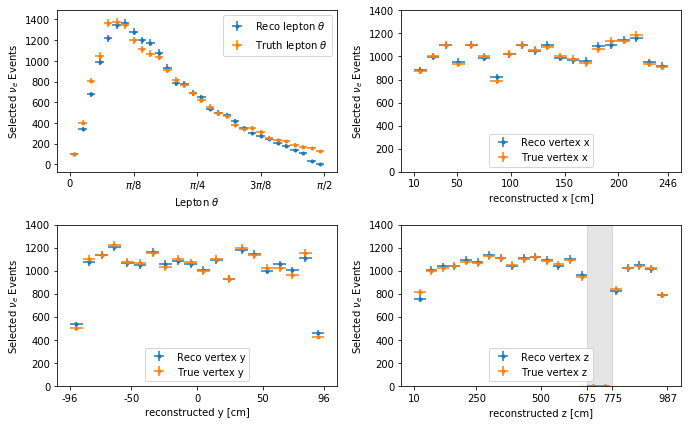

In [10]:
fig,ax=plt.subplots(ncols=2,nrows=2,figsize=(6*gr,6),sharey=False,sharex=False)

N = 30
min_x = 0.0
max_x = np.pi/2
binwidth=(max_x-min_x)/N
binhalf = binwidth/2
x_labels = [r'0', r'${\pi}/{8}$', r'${\pi}/{4}$', r'${3\pi}/{8}$',r'${\pi}/{2}$']
x_ticks = [0,np.pi/8,np.pi/4,3*np.pi/8,np.pi/2]

reco_theta, edges = np.histogram(df_nue_test_lite['reco_lepton_theta'],bins=N,range=(min_x,max_x),weights=df_nue_test_lite['bnbweight'])
true_theta, _     = np.histogram(df_nue_test_lite['lepton_theta'],bins=N,range=(min_x,max_x),weights=df_nue_test_lite['bnbweight'])

ax[0][0].errorbar(edges[:-1]+binhalf, reco_theta , xerr=binhalf, yerr=np.sqrt(reco_theta),alpha=1.0,fmt='.',label=r'Reco lepton $\theta$')
ax[0][0].errorbar(edges[:-1]+binhalf, true_theta , xerr=binhalf, yerr=np.sqrt(true_theta),alpha=1.0,fmt='.',label=r'Truth lepton $\theta$')
ax[0][0].legend()
ax[0][0].set_xlabel(r'Lepton $\theta$')
ax[0][0].set_ylabel(r'Selected $\nu_e$ Events')
ax[0][0].set_xticks(x_ticks)
ax[0][0].set_xticklabels(x_labels)

N=20
x_labels = ['10', '50', "100", '150','200',"246"]
x_ticks = [10, 50, 100, 150, 200, 246.35]
vtx_x, edges = np.histogram(df_nue_test_lite['vx'],bins=N,weights=df_nue_test_lite['bnbweight'])
vtx_true, _ = np.histogram(df_nue_test_lite['true_vx_sce'],edges,weights=df_nue_test_lite['bnbweight'])
binhalf = (edges[1]-edges[2])/2
ax[0][1].errorbar(edges[:-1]-binhalf, vtx_x , xerr=binhalf, yerr=np.sqrt(vtx_x),alpha=1.0,fmt='.',label=r'Reco vertex x')
ax[0][1].errorbar(edges[:-1]-binhalf, vtx_true , xerr=binhalf, yerr=np.sqrt(vtx_true),alpha=1.0,fmt='.',label=r'True vertex x')
ax[0][1].set_xlabel(r'reconstructed x [cm]')
ax[0][1].set_ylabel(r'Selected $\nu_e$ Events')
ax[0][1].legend()
ax[0][1].set_ylim(0,1400)
ax[0][1].legend(loc="lower center")
ax[0][1].set_xticks(x_ticks)
ax[0][1].set_xticklabels(x_labels)

N=22
x_labels = ['10', '250', "500", str(z_dead_start), str(z_dead_end), 987]
x_ticks = [10, 250,500, z_dead_start, z_dead_end, 986.8]
vtx_x, edges = np.histogram(df_nue_test_lite['vz'],bins=N,range=(10,990),weights=df_nue_test_lite['bnbweight'])
vtx_true, _ = np.histogram(df_nue_test_lite['true_vz_sce'],edges,weights=df_nue_test_lite['bnbweight'])
binhalf = (edges[1]-edges[2])/2
ax[1][1].errorbar(edges[:-1]-binhalf, vtx_x , xerr=binhalf, yerr=np.sqrt(vtx_x),alpha=1.0,fmt='.',label=r'Reco vertex z')
ax[1][1].errorbar(edges[:-1]-binhalf, vtx_true , xerr=binhalf, yerr=np.sqrt(vtx_true),alpha=1.0,fmt='.',label=r'True vertex z')
ax[1][1].set_xlabel(r'reconstructed z [cm]')
ax[1][1].set_ylabel(r'Selected $\nu_e$ Events')
ax[1][1].legend()
ax[1][1].axvspan(z_dead_start, z_dead_end, alpha=0.1, color='k')
ax[1][1].set_ylim(0,1400)
ax[1][1].legend(loc="lower center")
ax[1][1].set_xticks(x_ticks)
ax[1][1].set_xticklabels(x_labels)

N=20
x_labels = ['-96', '-50', "0", '50','96',]
x_ticks = [-96.5, -50, 0, 50, 96.5]
vtx_x, edges = np.histogram(df_nue_test_lite['vy'],bins=N,weights=df_nue_test_lite['bnbweight'])
vtx_true, _ = np.histogram(df_nue_test_lite['true_vy_sce'],edges,weights=df_nue_test_lite['bnbweight'])
binhalf = (edges[1]-edges[2])/2
ax[1][0].errorbar(edges[:-1]-binhalf, vtx_x , xerr=binhalf, yerr=np.sqrt(vtx_x),alpha=1.0,fmt='.',label=r'Reco vertex y')
ax[1][0].errorbar(edges[:-1]-binhalf, vtx_true , xerr=binhalf, yerr=np.sqrt(vtx_true),alpha=1.0,fmt='.',label=r'True vertex y')
ax[1][0].set_xlabel(r'reconstructed y [cm]')
ax[1][0].set_ylabel(r'Selected $\nu_e$ Events')
ax[1][0].legend(loc="lower center")
ax[1][0].set_ylim(0,1400)
ax[1][0].set_xticks(x_ticks)
ax[1][0].set_xticklabels(x_labels)

plt.tight_layout()
plt.savefig(output_dir+"after_check.pdf",
            transparant=True,
               bbox_inches='tight', 
               pad_inches=0.1)

other: no proton 22.62750458614239
other: yes_pion 13.938453807732147
other: no_p_yes_pi 7.24486027161215
other: 1eNp0pi 56.18918133451574
[26.05173796 45.8076116  21.69016284  4.95537311  1.49511449]


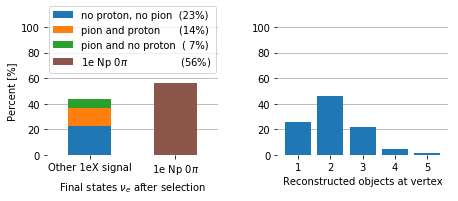

In [11]:
no_proton = sum(df_nue_test_selected.query("true_proton==0 and true_pion==0")["bnbweight"])
yes_pion = sum(df_nue_test_selected.query("true_proton==1 and true_pion==1")["bnbweight"])
no_p_yes_pi = sum(df_nue_test_selected.query("true_proton==0 and true_pion==1")["bnbweight"])
roberto = sum(df_nue_test_selected.query("true_proton==1 and true_pion==0")["bnbweight"])

total = sum(df_nue_test_selected["bnbweight"])
no_proton/=total/100
yes_pion/=total/100
no_p_yes_pi/=total/100
roberto/=total/100

print("other: no proton",no_proton)
print("other: yes_pion",yes_pion)
print("other: no_p_yes_pi",no_p_yes_pi)
print("other: 1eNp0pi",roberto)


shower = sum(df_nue_test_selected.query("n_showers==1 and n_tracks==0")["bnbweight"])

fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(4*gr,3),sharey=False,sharex=False)

x_ticks = [1,2]
x_labels = [r'Other 1eX signal', '1e Np 0$\pi$']
# You can specify a rotation for the tick labels in degrees or with keywords.
w=0.5
ax[0].yaxis.grid()
ax[0].set_axisbelow(True)
ax[0].bar(x_ticks[0], no_proton, w, align='center',label="no proton, no pion  ("+str(round(no_proton)) +"%)" )
ax[0].bar(x_ticks[0], yes_pion, w,bottom= no_proton, align='center',label="pion and proton      ("+str(round(yes_pion)) +"%)")
ax[0].bar(x_ticks[0], no_p_yes_pi, w,bottom= no_proton+yes_pion, align='center',label="pion and no proton  ( "+str(round(no_p_yes_pi)) +"%)")
ax[0].bar(x_ticks[1], roberto, w, align='center',color="C5",label="1e Np 0$\pi$                 ("+str(round(roberto)) +"%)")
ax[0].set_xticks(x_ticks)
ax[0].set_xticklabels( x_labels)
ax[0].set_frame_on(False)
ax[0].set_ylabel("Percent [%]")
ax[0].set_ylim(0,100)
ax[0].set_xlim(0.5,2.5)
ax[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.2))
ax[0].set_xlabel(r"Final states $\nu_e$ after selection")

N=5
count = np.zeros(N)
for i in range(N):
    count[i] = sum(df_nue_test_selected[df_nue_test_selected["vtx_activity_nr"]==i+1]["bnbweight"])
count/=sum(count)
count*=100

print(count)

#ax[1].set_ylabel("Percent [%]")
ax[1].yaxis.grid()
ax[1].set_axisbelow(True)
x_ticks = [1,2,3,4,5]
ax[1].set_ylim(0,100)
ax[1].bar(x_ticks, count)
ax[1].set_xlabel(r"Reconstructed objects at vertex")
ax[1].set_frame_on(False)
ax[1].set_xticks(x_ticks)

plt.tight_layout(w_pad=3.)
plt.savefig(output_dir+"after_channel.pdf", transparant=True, bbox_inches='tight', pad_inches=0.1)

/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


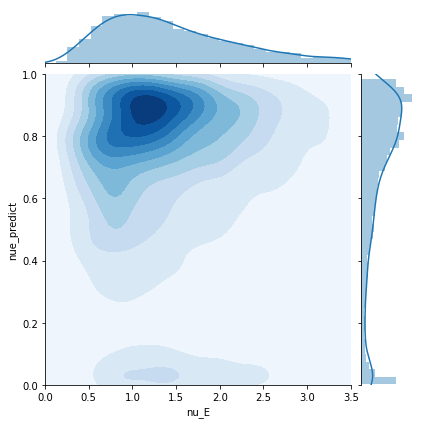

In [12]:
g = sns.JointGrid(x="nu_E", y=nue_method,data=df_nue_test.head(5000),xlim=(0,3.5),ylim=(0.0,1.0))
g.plot_joint(sns.kdeplot,shade=True,cmap="Blues") 
g.plot_marginals(sns.distplot,bins=40)